In [12]:
import numpy as np

import ngsolve 
from ngsolve.webgui import Draw
import netgen.geom2d


import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline

### Implicit Eulerian method for the heat equation 

WE are solving
$$\partial_t = \Delta u  $$ 
Weak form 
$$\int  \partial_t u v\ dx +  \int \nabla u \nabla v dx =0 \qquad \forall v$$

Implicit Euler
$$ \int \frac{(u^{n+1} - u^n)}{dt} v \ dx + \int \nabla u^{n+1} \nabla v dx  = 0 $$

Let $$ Mu = \int u v dx  \text { and  } 
L u = \int \nabla u \nabla v dx $$ 
\begin{align}
 M u^{n+1} - M u^n + dt L u^{n+1} &= 0 \\
M u^{n+1} + dt L u^{n+1} - M u^n  - dt L u^n + dt L u^n &= 0  \\
(M + dt L) ( u^{n+1} - u^n) + dt L u^n &= 0 
\end{align}
Let $$\delta = ( u^{n+1} - u^n) \text{  and } M_* = (M + dt L)$$
\begin{align}
\delta = M_*^{-1} (- dt L u^n)
\end{align}

In [2]:
# https://docu.ngsolve.org/latest/i-tutorials/unit-4.1.2-csg2d/csg2d.html
geo = netgen.geom2d.CSG2d()

# make a circle with a hole in it!
circle1 = netgen.geom2d.Circle( center=(0,0), radius=1.0,  bc="outer" )
circle2 = netgen.geom2d.Circle( center=(0.1,0), radius=0.3,  bc="inner" )

annulus = circle1 - circle2
geo.Add(annulus)

In [3]:
maxh_mesh=0.07
mesh = ngsolve.Mesh( geo.GenerateMesh(maxh=maxh_mesh))
Draw(mesh)
mesh.GetBoundaries()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

('outer', 'outer', 'outer', 'outer', 'inner', 'inner', 'inner', 'inner')

In [4]:
korder = 2
fes = ngsolve.H1(mesh, order=korder)    # if you want dirichlet BC:  ,dirichlet="inner|outer") 
u,v =  fes.TnT()  # create test and trial functions  

In [5]:
nu=0.1
dt = 0.01

# Laplacian  = L above
a = ngsolve.BilinearForm(fes)  # holds Laplacian operator for both fields 
a += nu*ngsolve.grad(u)*ngsolve.grad(v)*ngsolve.dx # This is laplacian 
a.Assemble()

# Mass matrix  = M above
m = ngsolve.BilinearForm(fes)  
m += u*v*ngsolve.dx 
m.Assemble()

# Inverse of mass matrix  M^-1
im = m.mat.CreateMatrix()
invm = im.Inverse(freedofs=fes.FreeDofs())  # in case we want an inverse!

# Mstar = dt L + M 
mstar = ngsolve.BilinearForm(fes) 
mstar +=  dt*nu*ngsolve.grad(u)*ngsolve.grad(v)*ngsolve.dx  + u*v*ngsolve.dx 
mstar.Assemble()

# Inverse of Mstar  = M_*^-1
ims = mstar.mat.CreateMatrix()
invmstar = ims.Inverse(freedofs=fes.FreeDofs())

# create thing to hold the solution 
gfu = ngsolve.GridFunction(fes)


In [29]:
# create initial conditions 
rho_0 = 0.0
x0=-0.5; y0=0.0; sig0=0.5; sig2= sig0*sig0
r2 = (ngsolve.x -x0) * (ngsolve.x  - x0) + (ngsolve.y-y0) * (ngsolve.y -y0)
rho_bump = 1.0*ngsolve.exp(-0.5*r2/sig2) + rho_0 # is a coefficient function 

# set the initial density field in the gfu solution field 
gfu.Set(rho_bump)
scene = Draw(gfu)

t=0 # initial time

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [30]:

tend=3.0  #end time 

while (t < tend-0.5*dt):
    res = -dt*a.mat* gfu.vec
    gfu.vec.data += invmstar * res
    scene.Redraw()
    t = t + dt;

In [44]:
# get node points and triangles from a 2d ngsolve-netgen triangular mesh
def pts_tri(mesh):
    # find the x,y coordinates of the mesh 
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0 # store nodes 
    for v in mesh.vertices:
        #print(v,v.point)
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    # get a list of triangles in the mesh
    triangles = np.zeros((mesh.ne,3), dtype =int)  # number of elements
    k=0  # store triangles 
    for el in mesh.Elements():
        triangles[k,:] = np.array([el.vertices[0].nr, el.vertices[1].nr, el.vertices[2].nr], dtype = int)
        k += 1
    return xv,yv,triangles

mesh2 = ngsolve.Mesh(geo.GenerateMesh (maxh=maxh_mesh/2))  # subdivide by 2
xv,yv,triangles = pts_tri(mesh2) # get coordinates and triangles from the higher resolution mesh

# let's see if we can write our own routine to display the output 
# mesh need not be that associated with gfu as we use triangular interpolation 
def disp(mesh,gfu,t,xv,yv,triangles,ofile):
    fig,ax= plt.subplots(1,1,figsize=(3.2,3),sharex=True,sharey=True,dpi=200)
    plt.subplots_adjust(left=0.15,right=0.95,bottom=0.06,top=0.99)
    ax.set_aspect('equal'); 
    
    uvals = np.zeros(mesh.nv)
    for k in range(mesh.nv):
        uvals[k] = gfu(mesh(xv[k],yv[k]))
        
    ax.tripcolor(xv, yv, uvals,  triangles=triangles,cmap='viridis')  # show field on triangles 
    
    field0 = ax.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0,shrink=0.7)  # colorbar!
    title = ax.set_title(f'$t$ = {t:.3f}')  # time stamp
    if (len(ofile)>2):
        plt.savefig(ofile)
    plt.show()


# helper routine for creating filenames 
def mkpngname(root,index):
    fnum = ''
    if (index < 10):
        fnum += '0'
    if  (index < 100):
        fnum += '0'
    ofile = root +  fnum + '{:d}'.format(index)   + '.png'
    print(ofile)
    return ofile

junk000.png


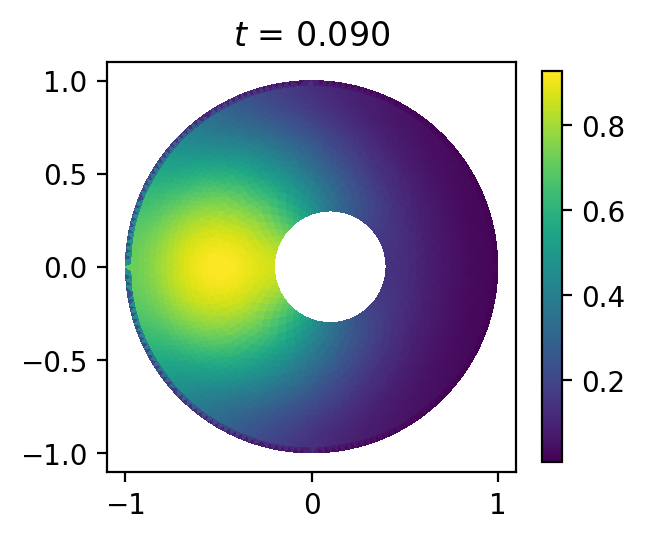

junk001.png


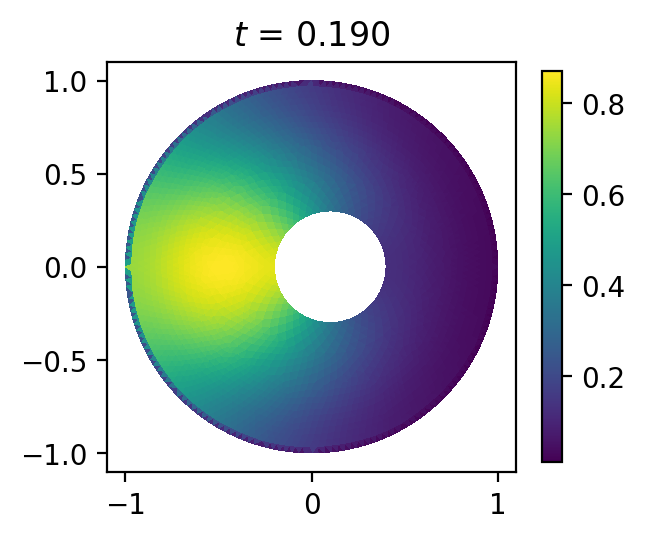

junk002.png


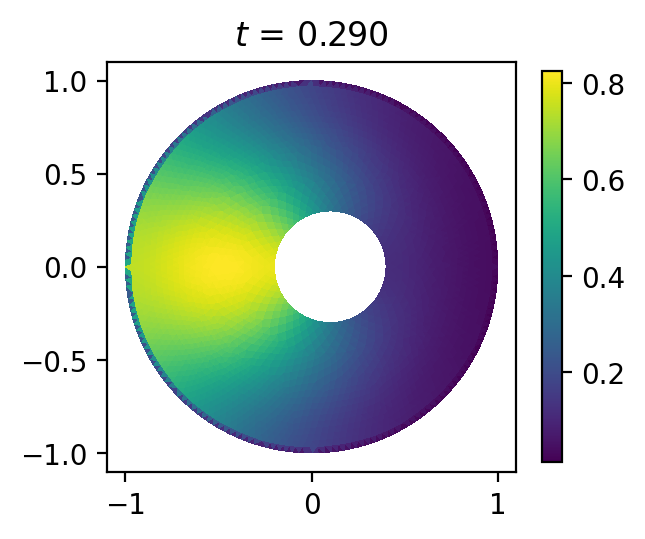

junk003.png


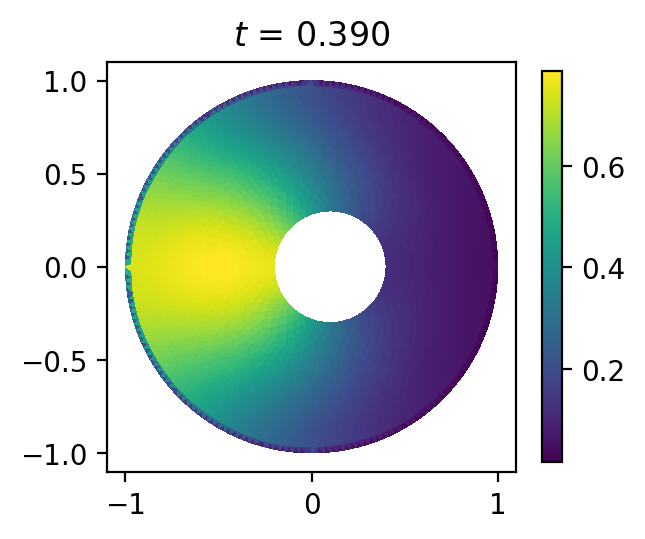

junk004.png


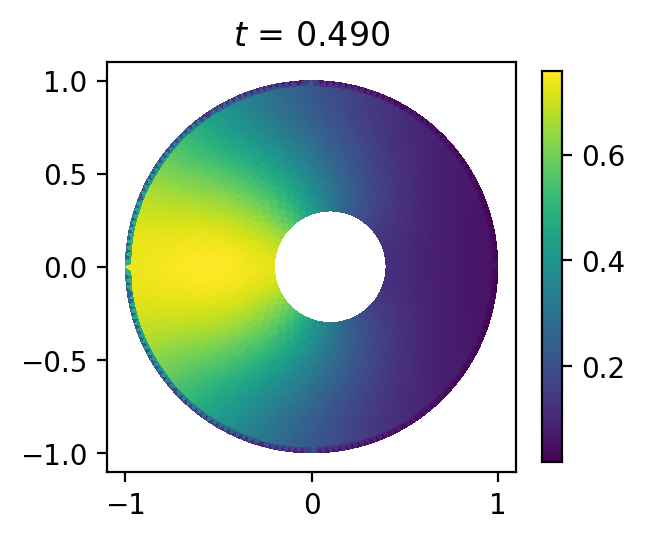

junk005.png


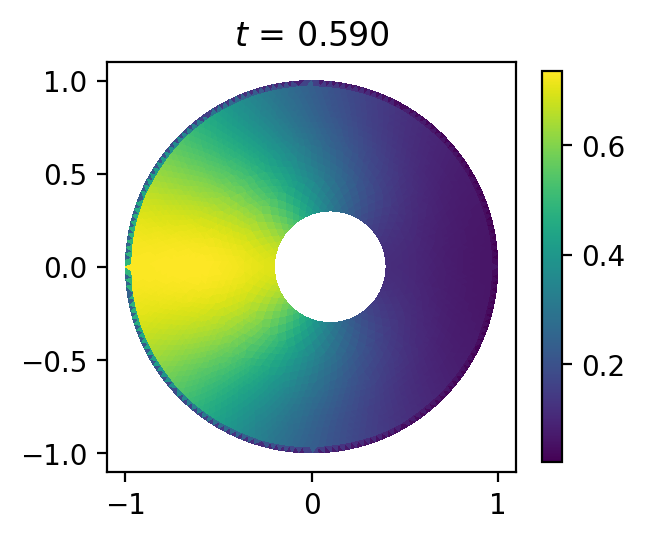

junk006.png


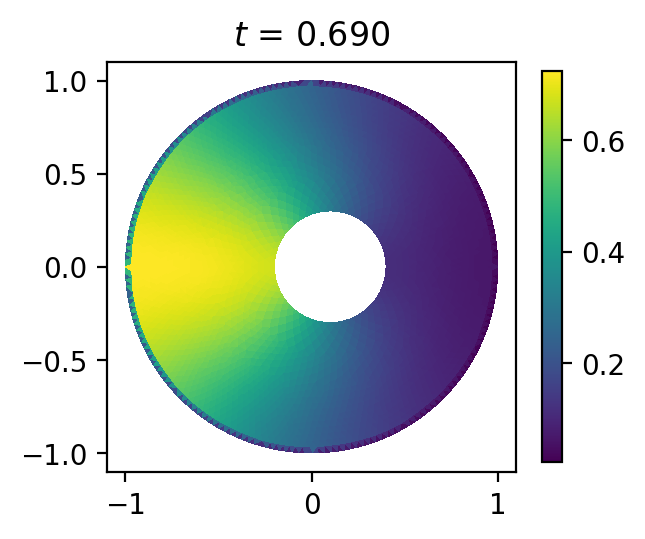

junk007.png


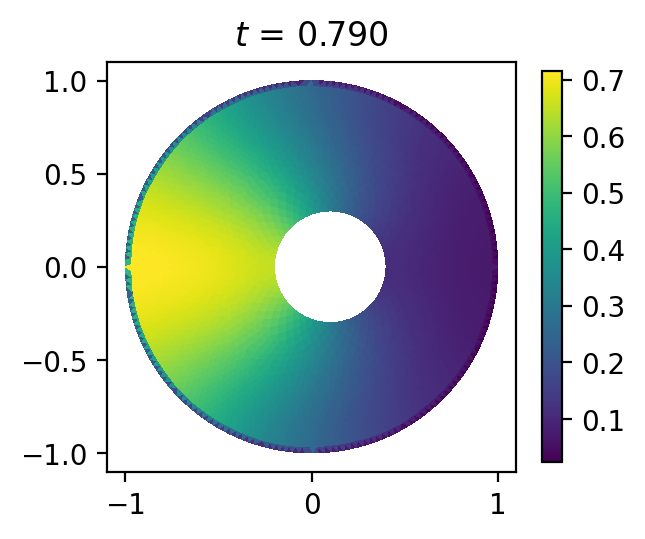

junk008.png


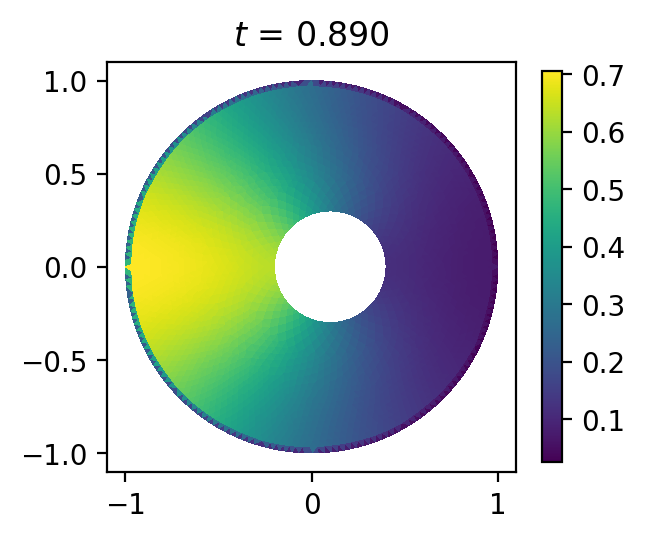

junk009.png


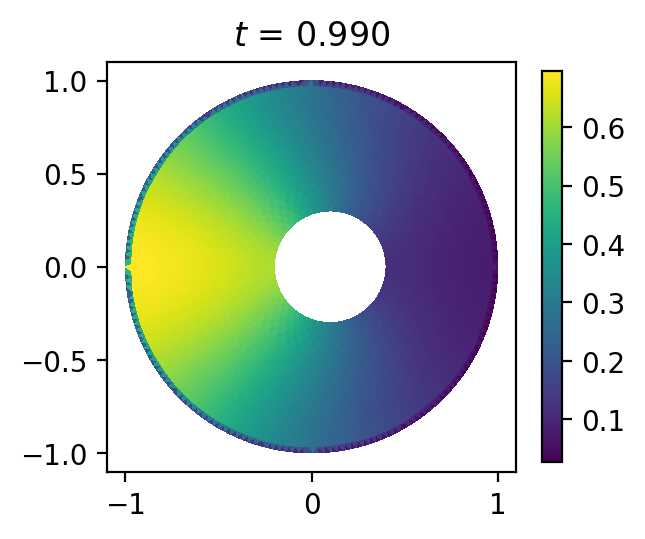

junk010.png


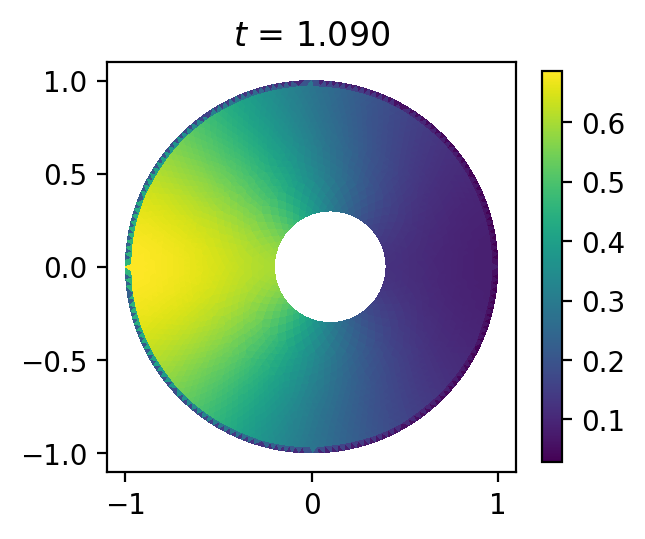

junk011.png


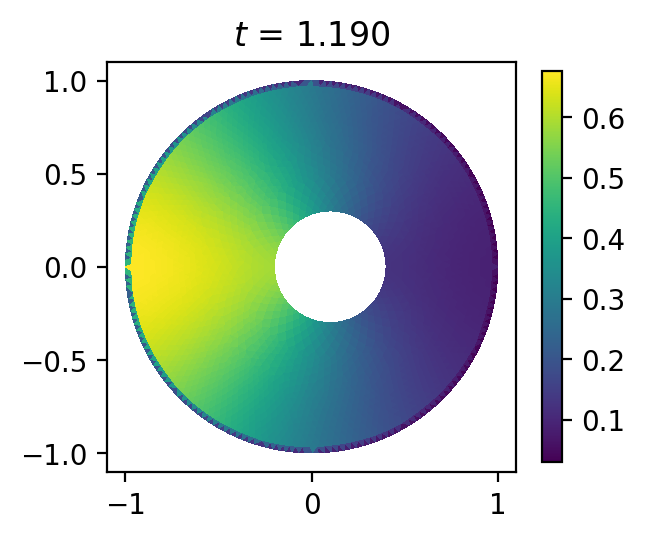

junk012.png


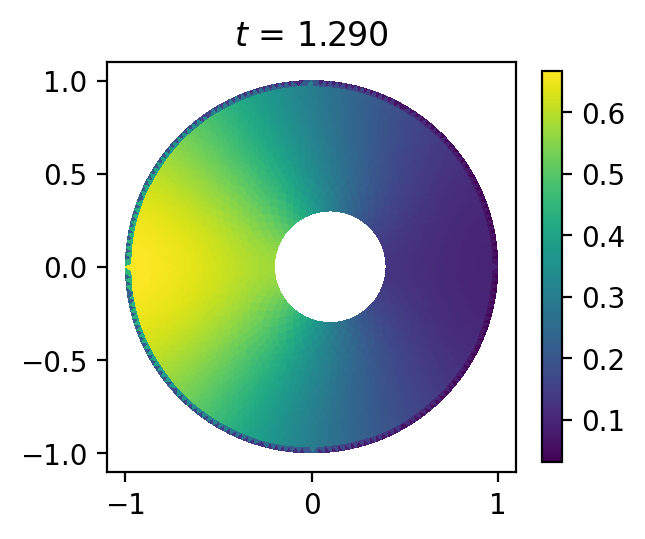

junk013.png


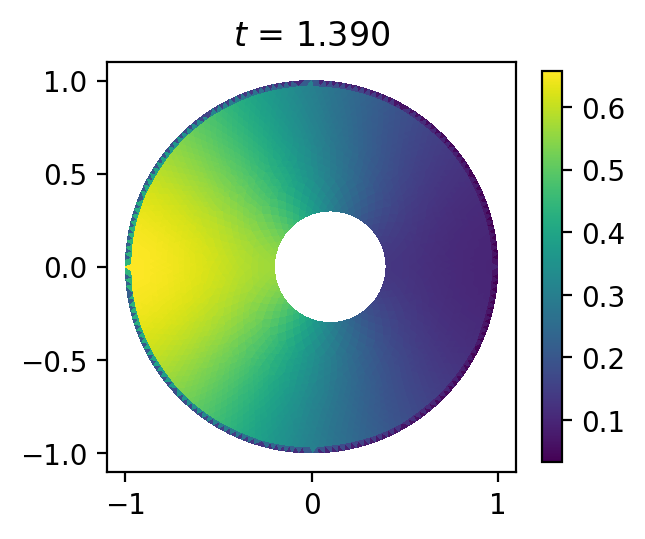

junk014.png


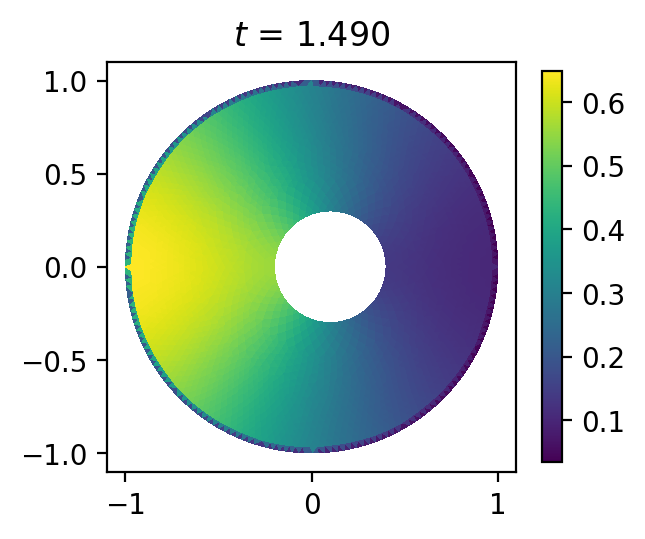

junk015.png


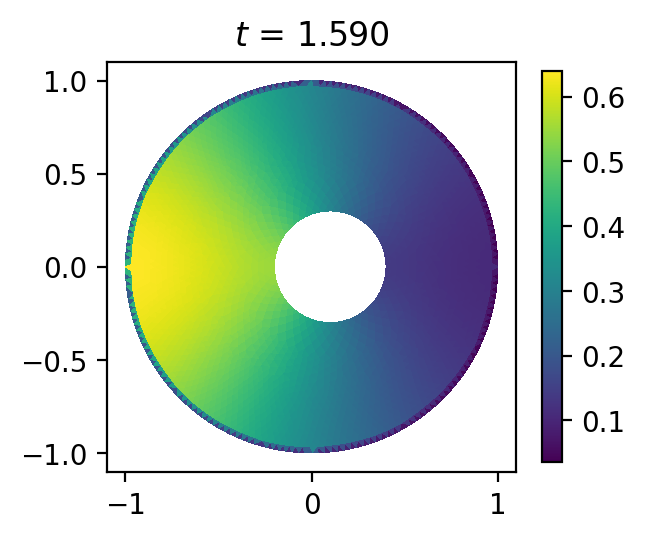

junk016.png


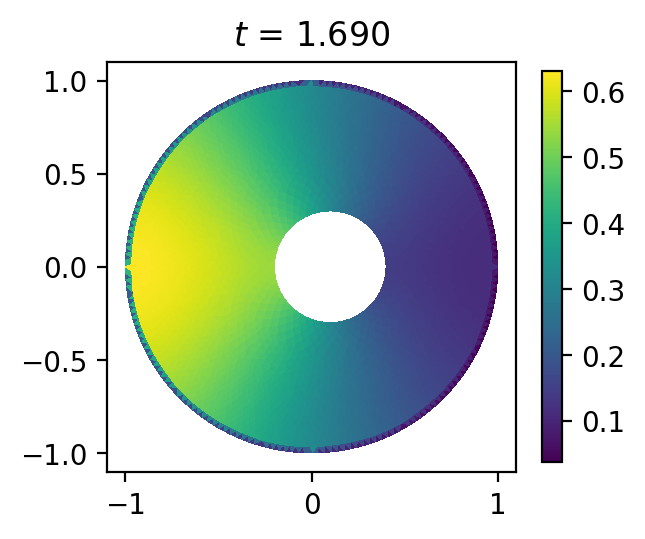

junk017.png


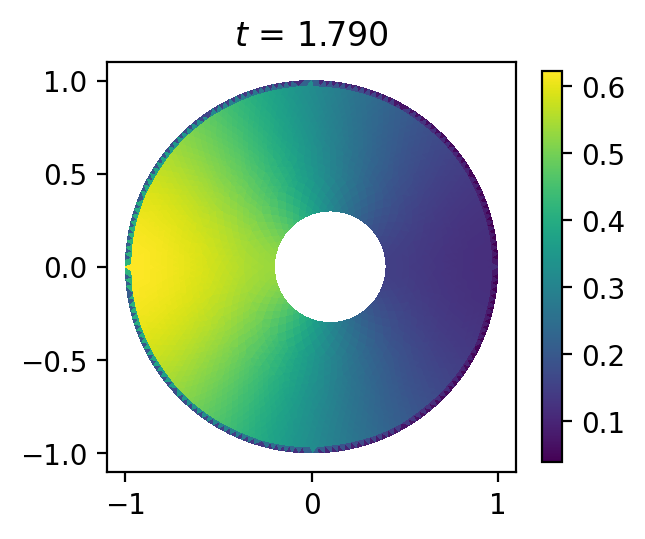

junk018.png


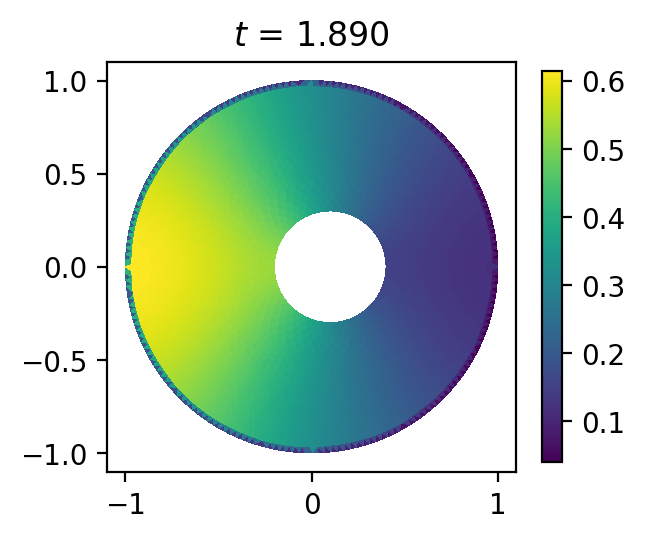

junk019.png


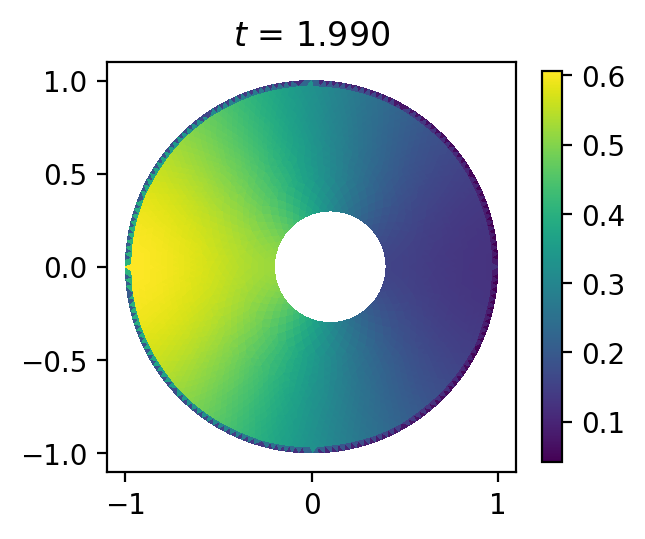

junk020.png


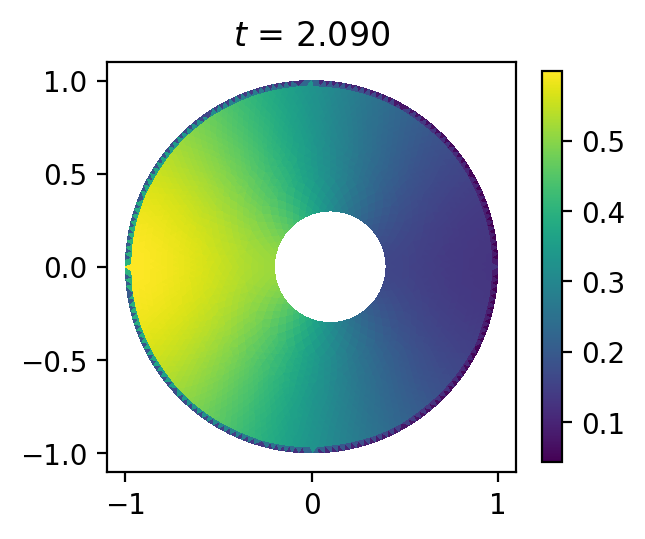

junk021.png


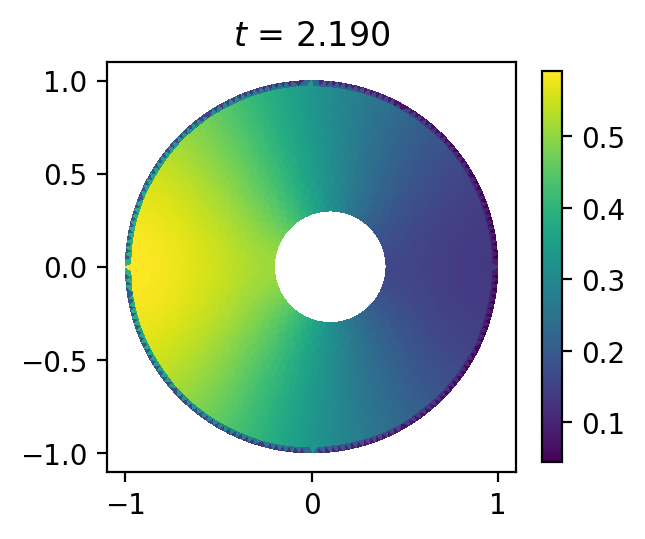

junk022.png


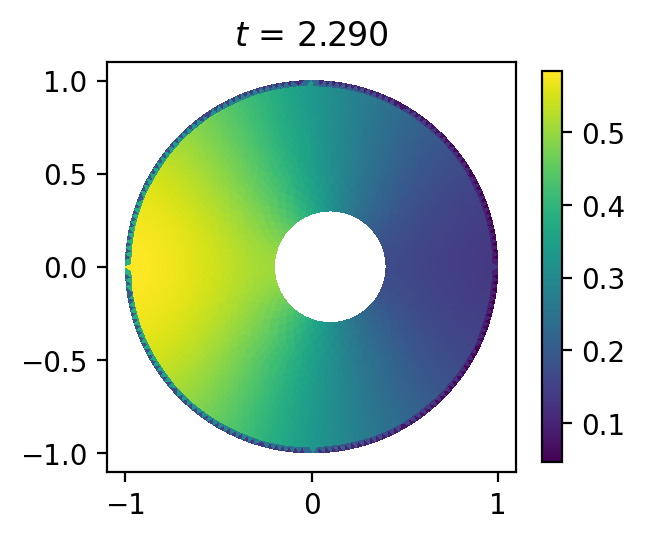

junk023.png


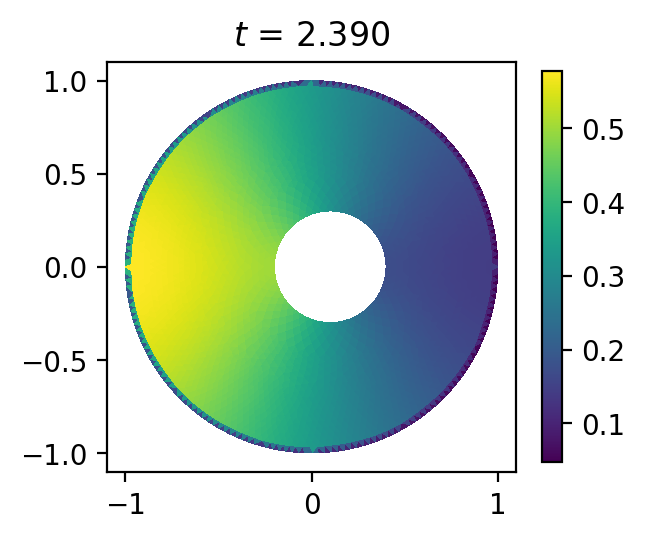

junk024.png


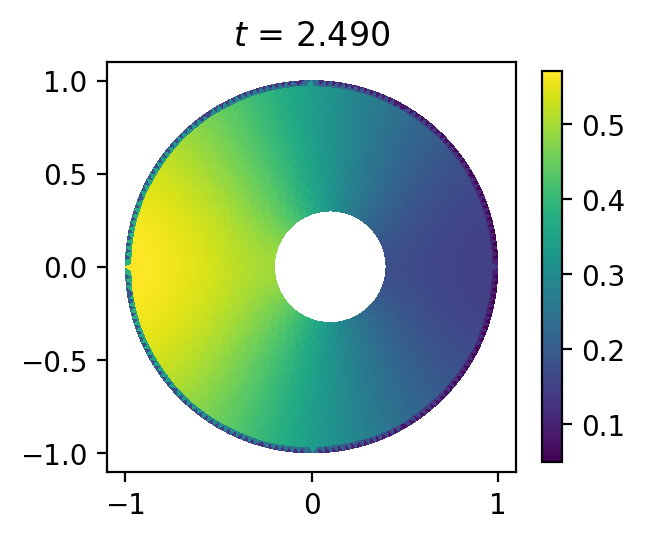

junk025.png


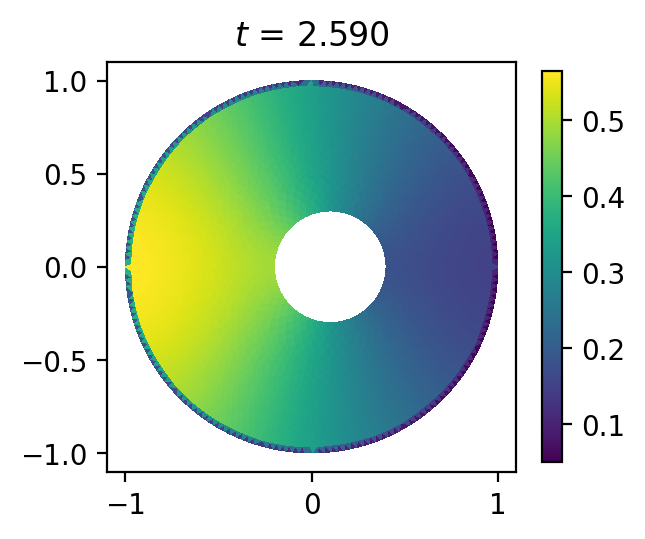

junk026.png


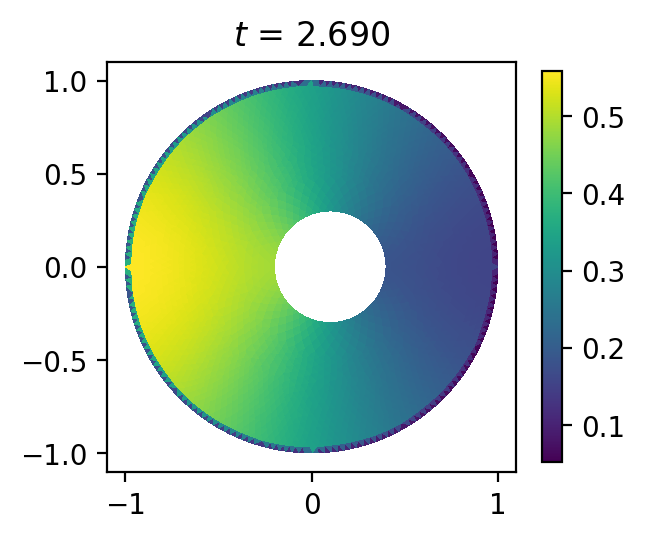

junk027.png


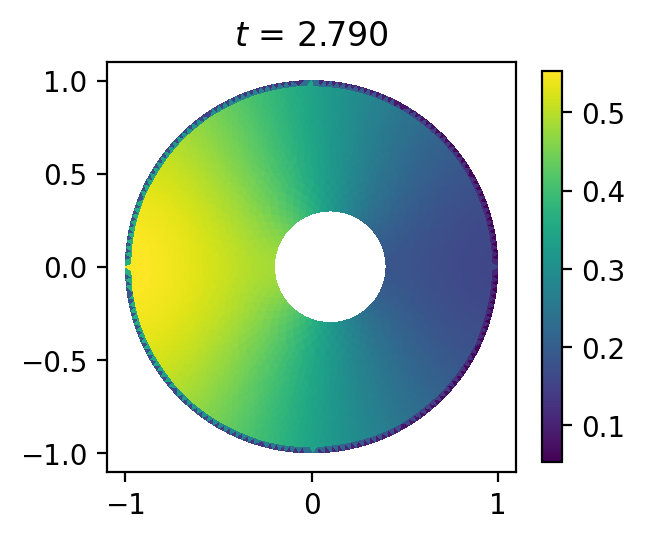

junk028.png


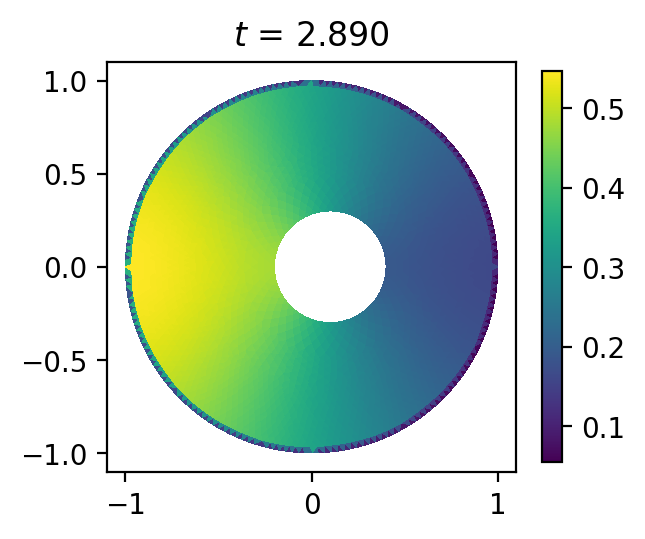

junk029.png


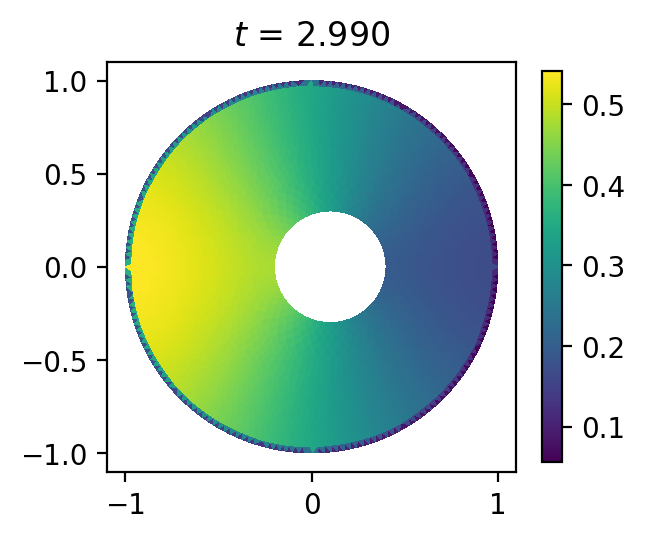

In [45]:
# set the initial density field in the gfu solution field  again 
gfu.Set(rho_bump)
#scene = Draw(gfu)
t=0 # initial time

tend=3.0  #end time 
ctn = 0  # count timesteps 
fcount = 0  # image count 
poutput = True  # do you want png output files?

while (t < tend-0.5*dt):
    res = -dt*a.mat* gfu.vec
    gfu.vec.data += invmstar * res
    #scene.Redraw()
    ctn += 1
    if (ctn % 10 == 0):  # only display every 10th image 
        if (poutput == True):
            root = "junk"
            ofile = mkpngname(root,fcount)
            disp(mesh2,gfu,t,xv,yv,triangles,ofile)
            fcount += 1 
        else:
            disp(mesh2,gfu,t,xv,yv,triangles,'')
    t = t + dt;